# **Bitcoin price prediction - Gradient Boosting Tree Regressor**
### Big Data Computing final project - A.Y. 2022 - 2023
Prof. Gabriele Tolomei

MSc in Computer Science

La Sapienza, University of Rome

### Author: Corsi Danilo (1742375) - corsi.1742375@studenti.uniroma1.it


---


Description: Executing the chosen model, first with default values, then choosing the best parameters by performing hyperparameter tuning with cross validation, performance evaluation and training of the final model

# Global constants, dependencies, libraries and tools

In [1]:
# Main constants
GDRIVE_DIR = "/content/drive"
MODEL_NAME = "GBTRegressor"
SLOW_OPERATIONS = True # Decide whether or not to use operations that might slow down notebook execution

In [2]:
###################
# --- DATASET --- #
###################

# Datasets dirs
GDRIVE_DATASET_OUTPUT_DIR = GDRIVE_DIR + "/MyDrive/BDC/project/datasets/output"

# Datasets names
DATASET_TRAIN_VALID_NAME = "bitcoin_blockchain_data_30min_train_valid"

# Datasets paths
GDRIVE_DATASET_TRAIN_VALID  = GDRIVE_DATASET_OUTPUT_DIR + "/" + DATASET_TRAIN_VALID_NAME + ".parquet"

####################
# --- FEATURES --- #
####################

# Features dir
GDRIVE_FEATURES_DIR = GDRIVE_DIR + "/MyDrive/BDC/project/features"

# Features labels
FEATURES_LABEL = "features"
TARGET_LABEL = "next-market-price"

# Features names
ALL_FEATURES_NAME = "all_features"
MOST_CORR_FEATURES_NAME = "most_corr_features"
LEAST_CORR_FEATURES_NAME = "least_corr_features"

# Features paths
GDRIVE_ALL_FEATURES = GDRIVE_FEATURES_DIR + "/" + ALL_FEATURES_NAME + ".json"
GDRIVE_MOST_CORR_FEATURES = GDRIVE_FEATURES_DIR + "/" + MOST_CORR_FEATURES_NAME + ".json"
GDRIVE_LEAST_CORR_FEATURES = GDRIVE_FEATURES_DIR + "/" + LEAST_CORR_FEATURES_NAME + ".json"

##################
# --- MODELS --- #
##################

# Model dir
GDRIVE_MODELS_DIR = GDRIVE_DIR + "/MyDrive/BDC/project/models"

# Model path
GDRIVE_MODEL = GDRIVE_MODELS_DIR + "/" + MODEL_NAME

#####################
# --- UTILITIES --- #
#####################

# Utilities dir
GDRIVE_UTILITIES_DIR = GDRIVE_DIR + "/MyDrive/BDC/project/utilities"

###################
# --- RESULTS --- #
###################

# Results dir
GDRIVE_RESULTS_DIR = GDRIVE_DIR + "/MyDrive/BDC/project/results"

# Results path
GDRIVE_MODEL_RESULTS  = GDRIVE_RESULTS_DIR + "/" + MODEL_NAME + ".csv"

In [3]:
# Point Colaboratory to Google Drive
from google.colab import drive

# Define GDrive paths
drive.mount(GDRIVE_DIR, force_remount=True)

Mounted at /content/drive


In [4]:
# Suppression of warnings for better reading
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
# Install Spark and related dependencies
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285387 sha256=483508fa1818a56de6d80bc1be01f9c005d5cdd681e2065ec09552f47a92849f
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


# Import files

In [6]:
# Import my files
import sys
sys.path.append(GDRIVE_UTILITIES_DIR)

from imports import *
import utilities, parameters

importlib.reload(utilities)
importlib.reload(parameters)

<module 'parameters' from '/content/drive/MyDrive/BDC/project/utilities/parameters.py'>

# Create the pyspark session

In [7]:
# Create the session
conf = SparkConf().\
                set('spark.ui.port', "4050").\
                set('spark.executor.memory', '4G').\
                set('spark.driver.memory', '45G').\
                set('spark.driver.maxResultSize', '10G').\
                set("spark.kryoserializer.buffer.max", "1G").\
                setAppName("BitcoinPricePrediction").\
                setMaster("local[*]")

# Create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

# Loading dataset

In [8]:
# Load datasets into pyspark dataset objects
df = spark.read.load(GDRIVE_DATASET_TRAIN_VALID,
                         format="parquet",
                         sep=",",
                         inferSchema="true",
                         header="true"
                    )

In [9]:
def dataset_info(dataset):
  # Print dataset
  dataset.show(3)

  # Get the number of rows
  num_rows = dataset.count()

  # Get the number of columns
  num_columns = len(dataset.columns)

  # Print the shape of the dataset
  print("Shape:", (num_rows, num_columns))

  # Print the schema of the dataset
  dataset.printSchema()

In [10]:
if SLOW_OPERATIONS:
  dataset_info(df)

+-------------------+---+------------------+--------------+-------------------+--------------+------------------+------------------+--------------------+------------------------+-----------------+-------------------+------------------+--------------------+------------------+------------------+--------------------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|          timestamp| id|      market-price|total-bitcoins|         market-cap|  trade-volume|       blocks-size|    avg-block-size|n-transactions-total|n-transactions-per-block|        hash-rate|         difficulty|    miners-revenue|transaction-fees-usd|n-unique-addresses|    n-transactions|estimated-transaction-volume-usd|      rate-of-change|        sma-5-days|        sma-7-days|       sma-10-days|       sma-20-days|       sma-50-days|      sma-100-days| next-market-price|
+-------------------+---+-----------

# Loading features

In [11]:
# Loading ALL FEATURES
with open(GDRIVE_ALL_FEATURES, "r") as f:
    ALL_FEATURES = json.load(f)
print(ALL_FEATURES)

['market-price', 'total-bitcoins', 'market-cap', 'trade-volume', 'blocks-size', 'avg-block-size', 'n-transactions-total', 'n-transactions-per-block', 'hash-rate', 'difficulty', 'miners-revenue', 'transaction-fees-usd', 'n-unique-addresses', 'n-transactions', 'estimated-transaction-volume-usd', 'rate-of-change', 'sma-5-days', 'sma-7-days', 'sma-10-days', 'sma-20-days', 'sma-50-days', 'sma-100-days']


In [12]:
# Loading MOST CORRELATED FEATURES
with open(GDRIVE_MOST_CORR_FEATURES, "r") as f:
    MOST_CORR_FEATURES = json.load(f)
print(MOST_CORR_FEATURES)

['market-price', 'market-cap', 'miners-revenue', 'sma-5-days', 'sma-7-days', 'sma-10-days', 'estimated-transaction-volume-usd', 'n-transactions-total', 'blocks-size', 'sma-100-days', 'total-bitcoins']


In [13]:
# Loading LEAST CORRELATED FEATURES
with open(GDRIVE_LEAST_CORR_FEATURES, "r") as f:
    LEAST_CORR_FEATURES = json.load(f)
print(LEAST_CORR_FEATURES)

['sma-20-days', 'sma-50-days', 'n-unique-addresses', 'difficulty', 'hash-rate', 'avg-block-size', 'transaction-fees-usd', 'trade-volume', 'n-transactions-per-block', 'n-transactions', 'rate-of-change']


# Model train / validation
In order to train and validate the model, we'll try several approaches:

* **Simple model:** Make predictions using the chosen base model
* **Simple model (with normalization):** Like the previous one but the selected features are normalized

At this point the features that gave on average the most satisfactory results (for each model) are chosen and proceeded with:

* **Hyperparameter tuning:** Model validation to find the best parameters to use
* **Cross Validation:** Validate the performance of the model with the chosen parameters
* **Validate final model:** Validate the model with the chosen parameters
* **Train final model:** Train the final model to be ready to make predictions using the validation set

## Simple model
The dataset is loaded, features are chosen, and then the dataset is divided into train set (90%) and validation set (10%).

The model is then trained on the train set and predictions are made on the validation set performing an overall evaluation of the model.


In [14]:
# Define model and features type
MODEL_TYPE = "simple"
FEATURES_NORMALIZATION = False

In [15]:
# Get default parameters
params = parameters.get_defaults_model_params(MODEL_NAME)
params

{'maxIter': [20], 'maxDepth': [5], 'stepSize': [0.1]}

In [16]:
# Make predictions by using all the features
simple_res_all, simple_pred_all = utilities.model_train_valid(df, params, MODEL_NAME, MODEL_TYPE, FEATURES_NORMALIZATION, ALL_FEATURES, ALL_FEATURES_NAME, FEATURES_LABEL, TARGET_LABEL)
simple_res_all

Model    Type      Features    Parameters         RMSE  \
0  GBTRegressor  simple  all_features  [20, 5, 0.1]  2448.382283   

            MSE          MAE      MAPE        R2  Adjusted_R2       Time  
0  5.994576e+06  1678.136716  0.069044  0.723193     0.723101  34.269258

In [17]:
utilities.show_results(simple_pred_all, MODEL_NAME)

In [18]:
# Make predictions by using the most correlated features
simple_res_most_corr, simple_pred_most_corr = utilities.model_train_valid(df, params, MODEL_NAME, MODEL_TYPE, FEATURES_NORMALIZATION, MOST_CORR_FEATURES, MOST_CORR_FEATURES_NAME, FEATURES_LABEL, TARGET_LABEL)
simple_res_most_corr

Model    Type            Features    Parameters         RMSE  \
0  GBTRegressor  simple  most_corr_features  [20, 5, 0.1]  3334.453404   

            MSE          MAE      MAPE        R2  Adjusted_R2       Time  
0  1.111858e+07  2513.650149  0.095245  0.486585     0.486416  20.620318

In [19]:
utilities.show_results(simple_pred_most_corr, MODEL_NAME)

In [20]:
# Make predictions by using the least correlated features
simple_res_least_corr, simple_pred_least_corr = utilities.model_train_valid(df, params, MODEL_NAME, MODEL_TYPE, FEATURES_NORMALIZATION, LEAST_CORR_FEATURES, LEAST_CORR_FEATURES_NAME, FEATURES_LABEL, TARGET_LABEL)
simple_res_least_corr

Model    Type             Features    Parameters        RMSE  \
0  GBTRegressor  simple  least_corr_features  [20, 5, 0.1]  6930.45586   

            MSE          MAE     MAPE        R2  Adjusted_R2       Time  
0  4.803122e+07  5870.932306  0.23576 -1.217904    -1.218636  19.603332

In [21]:
utilities.show_results(simple_pred_least_corr, MODEL_NAME)

## Simple model (with normalization)
Same as "Simple model" but selected features are normalized.

In [22]:
# Define model and features type
MODEL_TYPE = "simple_norm"
FEATURES_NORMALIZATION = True

In [23]:
# Valid performances with all the features
simple_norm_res_all, simple_norm_pred_all = utilities.model_train_valid(df, params, MODEL_NAME, MODEL_TYPE, FEATURES_NORMALIZATION, ALL_FEATURES, ALL_FEATURES_NAME, FEATURES_LABEL, TARGET_LABEL)
simple_norm_res_all

Model         Type      Features    Parameters          RMSE  \
0  GBTRegressor  simple_norm  all_features  [20, 5, 0.1]  13931.399705   

            MSE           MAE      MAPE        R2  Adjusted_R2       Time  
0  1.940839e+08  12861.321014  0.537381 -7.962076    -7.965036  17.959856

In [24]:
utilities.show_results(simple_norm_pred_all, MODEL_NAME)

In [25]:
# Make predictions by using the most the features
simple_norm_res_most_corr, simple_norm_pred_most_corr = utilities.model_train_valid(df, params, MODEL_NAME, MODEL_TYPE, FEATURES_NORMALIZATION, MOST_CORR_FEATURES, MOST_CORR_FEATURES_NAME, FEATURES_LABEL, TARGET_LABEL)
simple_norm_res_most_corr

Model         Type            Features    Parameters         RMSE  \
0  GBTRegressor  simple_norm  most_corr_features  [20, 5, 0.1]  3049.928569   

            MSE         MAE     MAPE        R2  Adjusted_R2       Time  
0  9.302064e+06  2173.12811  0.08662  0.570465     0.570323  16.965165

In [26]:
utilities.show_results(simple_norm_pred_most_corr, MODEL_NAME)

In [27]:
# Make predictions by using the least the features
simple_norm_res_least_corr, simple_norm_pred_least_corr = utilities.model_train_valid(df, params, MODEL_NAME, MODEL_TYPE, FEATURES_NORMALIZATION, LEAST_CORR_FEATURES, LEAST_CORR_FEATURES_NAME, FEATURES_LABEL, TARGET_LABEL)
simple_norm_res_least_corr

Model         Type             Features    Parameters         RMSE  \
0  GBTRegressor  simple_norm  least_corr_features  [20, 5, 0.1]  6507.890846   

            MSE          MAE    MAPE        R2  Adjusted_R2       Time  
0  4.235264e+07  5409.099339  0.2155 -0.955688    -0.956334  21.313523

In [28]:
utilities.show_results(simple_norm_pred_least_corr, MODEL_NAME)

In [29]:
# Concatenate simple results into Pandas Dataframe
simple_model_results_df = pd.DataFrame(pd.concat([simple_res_all, simple_res_most_corr, simple_res_least_corr,simple_norm_res_all, simple_norm_res_most_corr, simple_norm_res_least_corr], ignore_index=True))
simple_model_results_df

Model         Type             Features    Parameters          RMSE  \
0  GBTRegressor       simple         all_features  [20, 5, 0.1]   2448.382283   
1  GBTRegressor       simple   most_corr_features  [20, 5, 0.1]   3334.453404   
2  GBTRegressor       simple  least_corr_features  [20, 5, 0.1]   6930.455860   
3  GBTRegressor  simple_norm         all_features  [20, 5, 0.1]  13931.399705   
4  GBTRegressor  simple_norm   most_corr_features  [20, 5, 0.1]   3049.928569   
5  GBTRegressor  simple_norm  least_corr_features  [20, 5, 0.1]   6507.890846   

            MSE           MAE      MAPE        R2  Adjusted_R2       Time  
0  5.994576e+06   1678.136716  0.069044  0.723193     0.723101  34.269258  
1  1.111858e+07   2513.650149  0.095245  0.486585     0.486416  20.620318  
2  4.803122e+07   5870.932306  0.235760 -1.217904    -1.218636  19.603332  
3  1.940839e+08  12861.321014  0.537381 -7.962076    -7.965036  17.959856  
4  9.302064e+06   2173.128110  0.086620  0.570465     0.570323  16.965165  
5  4.235264e+07   5409.099339  0.215500 -0.955688    -0.956334  21.313523

## Hyperparameter tuning
The dataset is divided into train data and validation data based on a portion list.

For each split that is made, all combinations of the model parameters are tested and those that return a lower RMSE are considered.

In [30]:
# From now on, only selected and normalized features will be considered
MODEL_TYPE = "hyp_tuning"
CHOSEN_FEATURES = MOST_CORR_FEATURES
CHOSEN_FEATURES_LABEL = MOST_CORR_FEATURES_NAME
FEATURES_NORMALIZATION = True

In [31]:
# Split proportion list
proportion_lst = parameters.get_proportion_lst()
proportion_lst

[0.92, 0.95, 0.97]

In [32]:
# Get model grid parameters
params = parameters.get_model_grid_params(MODEL_NAME)
params

{'maxIter': [10, 20, 30], 'maxDepth': [3, 5, 8], 'stepSize': [0.1, 0.4, 0.7]}

In [33]:
# Perform hyperparameter tuning
hyp_res, hyp_params = utilities.hyperparameter_tuning(df, params, proportion_lst, MODEL_NAME, MODEL_TYPE, FEATURES_NORMALIZATION, CHOSEN_FEATURES, CHOSEN_FEATURES_LABEL, FEATURES_LABEL, TARGET_LABEL)
hyp_res

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


Py4JError: ignored

## Cross validation ❗
Using the previously selected parameters, the model undergoes two types of cross validation:



**Multiple splits**

The idea is to divide the dataset into two folds at each iteration on condition that the validation set is always ahead of the training set. This way dependence is respected.

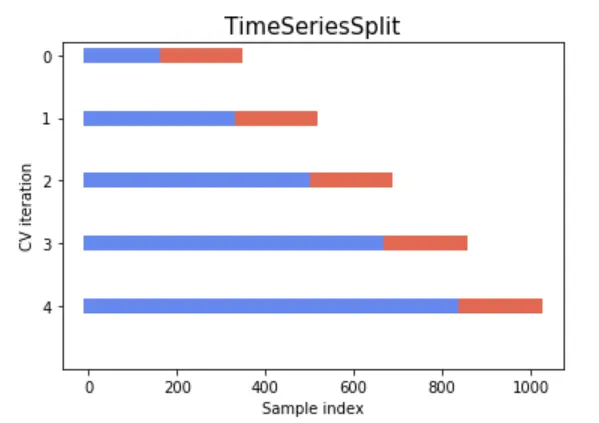

**Blocked time series**

It works by adding margins at two positions. The first is between the training and validation folds in order to prevent the model from observing lag values which are used twice, once as a regressor and another as a response. The second is between the folds used at each iteration in order to prevent the model from memorizing patterns from an iteration to the next.

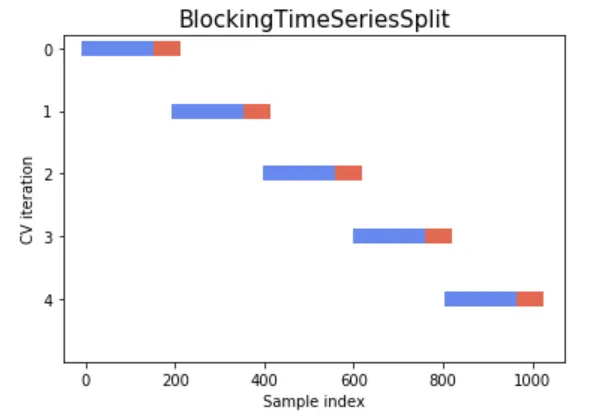

In [ ]:
# Get tuned parameters
params = hyp_params
params

In [ ]:
# Multiple splits time series cross validation parameters
multi_splits = {'cv_type':'multi_splits',
          'splits': 5}

# Blocked time series cross validation parameters
block_splits = {'cv_type':'block_splits',
          'splits': 10}

In [ ]:
# Perform multiple splits time series cross validation
mul_cv_res = utilities.cross_validation(df, params, multi_splits, MODEL_NAME, FEATURES_NORMALIZATION, CHOSEN_FEATURES, CHOSEN_FEATURES_LABEL, FEATURES_LABEL, TARGET_LABEL)
mul_cv_res

In [ ]:
# Perform blocked time series cross validation parameters
blk_cv_res = utilities.cross_validation(df, params, block_splits, MODEL_NAME, FEATURES_NORMALIZATION, CHOSEN_FEATURES, CHOSEN_FEATURES_LABEL, FEATURES_LABEL, TARGET_LABEL)
blk_cv_res

## Validate final model
Performing model validation using the parameters chosen on the dataset divided into train set (90%) and validation set (10%).

In [ ]:
MODEL_TYPE = "final_validated"

In [ ]:
# Performances on validated final model
final_valid_res, final_valid_pred = utilities.model_train_valid(df, params, MODEL_NAME, MODEL_TYPE, FEATURES_NORMALIZATION, CHOSEN_FEATURES, CHOSEN_FEATURES_LABEL, FEATURES_LABEL, TARGET_LABEL)
final_valid_res

In [ ]:
utilities.show_results(final_valid_pred, MODEL_NAME)

## Train final model
Performing model training using the parameters chosen on the whole train / validation set.

In [ ]:
MODEL_TYPE = "final_trained"

In [ ]:
# Train the model on the whole train / validation set
final_train_res, final_train_model, final_train_pred = utilities.evaluate_trained_model(df, params, MODEL_NAME, MODEL_TYPE, FEATURES_NORMALIZATION, CHOSEN_FEATURES, CHOSEN_FEATURES_LABEL, FEATURES_LABEL, TARGET_LABEL)
final_train_res

In [ ]:
utilities.show_results(final_train_pred, MODEL_NAME)

# Comparison table
Visualization of model performance at various stages of train / validation

In [ ]:
# Define model information and evaluators to show
model_info = ['Model','Type', 'Features', 'Parameters']
evaluator_lst = ['RMSE', 'MSE', 'MAE', 'MAPE', 'R2', 'Adjusted_R2', 'Time']

# Define the results to show
comparison_lst = [simple_res_all, simple_res_most_corr, simple_res_least_corr,
                  simple_norm_res_all, simple_norm_res_most_corr, simple_norm_res_least_corr,
                  hyp_res, mul_cv_res, blk_cv_res, final_valid_res, final_train_res
                  ]

In [ ]:
# Show the comparison table
comparison_lst_df = pd.concat([utilities.model_comparison(results, model_info, evaluator_lst) for results in comparison_lst])
comparison_lst_df

# Saving trained model


In [ ]:
# Saving final model results
comparison_lst_df.to_csv(GDRIVE_MODEL_RESULTS, index=False)

In [ ]:
# Save the trained model
final_train_model.write().overwrite().save(GDRIVE_MODEL)